In [175]:
# Importar bibliotecas necesarias
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import col, count, isnan, when, trim, to_timestamp, datediff, current_date, unix_timestamp,col, udf, when
from pyspark.sql.types import StringType, IntegerType, FloatType, TimestampType
from pyspark.sql.window import Window
from functools import reduce
from pyspark.sql import Row
from pyspark.sql.functions import lit, sum as spark_sum, avg

1. Crear y inicializar SPARK

In [176]:
# Inicializar SparkSession
spark = SparkSession.builder \
    .appName("Marketin-predictivo") \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .getOrCreate()

2. Leer los datasets

In [177]:
# Caminos para los archivos
path_clientes_emp1 = "/home/jovyan/Marketing-Predictivo/CSV/emp1_clientes_anonimizados.csv"
path_produtos_emp1 = "/home/jovyan/Marketing-Predictivo/CSV/emp1_productos_con_atributos.csv"
path_ordens_emp1 = "/home/jovyan/Marketing-Predictivo/CSV/emp1_historico_ordenes.csv"

path_clientes_emp2 = "/home/jovyan/Marketing-Predictivo/CSV/emp2_clientes_anonimizados.csv"
path_produtos_emp2 = "/home/jovyan/Marketing-Predictivo/CSV/emp2_productos_con_atributos.csv"
path_ordens_emp2 = "/home/jovyan/Marketing-Predictivo/CSV/emp2_historico_ordenes.csv"



In [178]:
df_clientes_emp1 = spark.read.csv(path_clientes_emp1, header=True, inferSchema=True, sep=',')
df_clientes_emp1.printSchema()
df_clientes_emp1.show(5, truncate=False)

root
 |-- user_id: integer (nullable = true)
 |-- user_registered: date (nullable = true)
 |-- user_status: integer (nullable = true)
 |-- billing_city: string (nullable = true)
 |-- billing_country: string (nullable = true)
 |-- billing_state: string (nullable = true)

+-------+---------------+-----------+------------+---------------+-------------+
|user_id|user_registered|user_status|billing_city|billing_country|billing_state|
+-------+---------------+-----------+------------+---------------+-------------+
|4      |2024-04-05     |0          |Lima        |PE             |LMA          |
|8      |2024-04-12     |0          |AREQUIPA    |PE             |ARE          |
|10     |2024-04-12     |0          |LIMA        |PE             |LIM          |
|13     |2024-04-15     |0          |Arequipa    |PE             |ARE          |
|14     |2024-04-15     |0          |NULL        |NULL           |NULL         |
+-------+---------------+-----------+------------+---------------+-------------+


In [179]:
df_clientes_emp2 = spark.read.csv(path_clientes_emp2, header=True, inferSchema=True, sep=',')
df_clientes_emp2.printSchema()
df_clientes_emp2.show(5, truncate=False)

root
 |-- user_id: integer (nullable = true)
 |-- user_registered: date (nullable = true)
 |-- user_status: integer (nullable = true)
 |-- billing_city: string (nullable = true)
 |-- billing_country: string (nullable = true)
 |-- billing_state: string (nullable = true)

+-------+---------------+-----------+------------+---------------+-------------+
|user_id|user_registered|user_status|billing_city|billing_country|billing_state|
+-------+---------------+-----------+------------+---------------+-------------+
|3      |2020-07-13     |0          |Peru        |PE             |LMA          |
|9      |2020-12-07     |0          |NULL        |NULL           |NULL         |
|12     |2020-12-11     |0          |NULL        |NULL           |NULL         |
|13     |2020-12-12     |0          |NULL        |NULL           |NULL         |
|18     |2020-12-13     |0          |NULL        |NULL           |NULL         |
+-------+---------------+-----------+------------+---------------+-------------+


In [180]:
df_produtos_emp1 = spark.read.csv(path_produtos_emp1, header=True, inferSchema=False, sep=',', multiLine=True, escape='"')
df_produtos_emp1 = df_produtos_emp1.withColumn("product_id", col("product_id").cast(IntegerType())) \
                       .withColumn("_price", col("_price").cast(FloatType())) \
                       .withColumn("_regular_price", col("_regular_price").cast(FloatType())) \
                       .withColumn("_sale_price", col("_sale_price").cast(FloatType())) \
                       .withColumn("total_sales", col("total_sales").cast(IntegerType())) \
                       .withColumn("_stock", col("_stock").cast(FloatType()))
df_produtos_emp1.printSchema()
df_produtos_emp1.show(10, truncate=True)

root
 |-- product_id: integer (nullable = true)
 |-- custom_partnumber: string (nullable = true)
 |-- post_title: string (nullable = true)
 |-- post_excerpt: string (nullable = true)
 |-- _sku: string (nullable = true)
 |-- _price: float (nullable = true)
 |-- _regular_price: float (nullable = true)
 |-- _sale_price: float (nullable = true)
 |-- total_sales: integer (nullable = true)
 |-- _backorders: string (nullable = true)
 |-- _stock: float (nullable = true)
 |-- _stock_status: string (nullable = true)
 |-- minimum_allowed_quantity: string (nullable = true)
 |-- custom_condition: string (nullable = true)
 |-- custom_eta: string (nullable = true)
 |-- custom_moq: string (nullable = true)
 |-- _product_attributes: string (nullable = true)
 |-- pa_1: string (nullable = true)
 |-- pa_almacenamiento: string (nullable = true)
 |-- pa_color: string (nullable = true)
 |-- pa_condicion: string (nullable = true)
 |-- pa_disco-duro: string (nullable = true)
 |-- pa_emmc: string (nullable = tr

In [181]:
df_produtos_emp1.show(10, truncate=True)

+----------+-----------------+--------------------+--------------------+-------------------+------+--------------+-----------+-----------+-----------+------+-------------+------------------------+----------------+----------+----------+--------------------+----+-----------------+--------+------------+-------------+-------+-----------+--------+--------------+-------------+-------------+------+--------------------+-------------------+----------+----------------+
|product_id|custom_partnumber|          post_title|        post_excerpt|               _sku|_price|_regular_price|_sale_price|total_sales|_backorders|_stock|_stock_status|minimum_allowed_quantity|custom_condition|custom_eta|custom_moq| _product_attributes|pa_1|pa_almacenamiento|pa_color|pa_condicion|pa_disco-duro|pa_emmc|pa_garantia|pa_marca|pa_memoria-ram|  pa_pantalla|pa_procesador|pa_ram|pa_sistema-operativo|pa_tarjeta-de-video|pa_teclado|pa_unidad-solida|
+----------+-----------------+--------------------+--------------------+

In [182]:
df_produtos_emp2 = spark.read.csv(path_produtos_emp2, header=True, inferSchema=False, sep=',', multiLine=True, escape='"')
df_produtos_emp2 = df_produtos_emp2.withColumn("product_id", col("product_id").cast(IntegerType())) \
                       .withColumn("_price", col("_price").cast(FloatType())) \
                       .withColumn("_regular_price", col("_regular_price").cast(FloatType())) \
                       .withColumn("total_sales", col("total_sales").cast(IntegerType())) \
                       .withColumn("_stock", col("_stock").cast(FloatType()))
df_produtos_emp2.printSchema()
df_produtos_emp2.show(10, truncate=True)

root
 |-- product_id: integer (nullable = true)
 |-- custom_partnumber: string (nullable = true)
 |-- post_title: string (nullable = true)
 |-- post_excerpt: string (nullable = true)
 |-- _sku: string (nullable = true)
 |-- _price: float (nullable = true)
 |-- _regular_price: float (nullable = true)
 |-- total_sales: integer (nullable = true)
 |-- _backorders: string (nullable = true)
 |-- _stock: float (nullable = true)
 |-- _stock_status: string (nullable = true)
 |-- minimum_allowed_quantity: string (nullable = true)
 |-- custom_condition: string (nullable = true)
 |-- custom_eta: string (nullable = true)
 |-- _product_attributes: string (nullable = true)
 |-- pa_brand: string (nullable = true)
 |-- pa_cell-phone-display-size: string (nullable = true)
 |-- pa_color: string (nullable = true)
 |-- pa_computer-operating-system: string (nullable = true)
 |-- pa_computer-processor-type: string (nullable = true)
 |-- pa_computer-ram-capacity: string (nullable = true)
 |-- pa_condition: st

In [183]:
df_produtos_emp2.show(10, truncate=True)

+----------+-----------------+--------------------+--------------------+----------------+------+--------------+-----------+-----------+------+-------------+------------------------+----------------+----------+--------------------+--------+--------------------------+--------+----------------------------+--------------------------+------------------------+------------+---------------+-----------------+-----------+----------------------+--------+------------------+----------+---------------+
|product_id|custom_partnumber|          post_title|        post_excerpt|            _sku|_price|_regular_price|total_sales|_backorders|_stock|_stock_status|minimum_allowed_quantity|custom_condition|custom_eta| _product_attributes|pa_brand|pa_cell-phone-display-size|pa_color|pa_computer-operating-system|pa_computer-processor-type|pa_computer-ram-capacity|pa_condition|pa_graphic-card|pa_hard-disk-size|pa_keyboard|pa_laptop-display-size|pa_notes|pa_solid-disk-size|pa_storage|    pa_warranty|
+----------+

In [184]:
df_ordens_emp1 = spark.read.csv(path_ordens_emp1, header=True, inferSchema=True, sep=',')
df_ordens_emp1.printSchema()
df_ordens_emp1.show(5, truncate=False)

root
 |-- order_id: integer (nullable = true)
 |-- order_date: date (nullable = true)
 |-- order_device_type: string (nullable = true)
 |-- order_session_visited_pages: integer (nullable = true)
 |-- order_session_start_time: date (nullable = true)
 |-- order_traffic_source_type: string (nullable = true)
 |-- order_utm_source_campaign: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- product_qty: integer (nullable = true)
 |-- product_net_revenue: double (nullable = true)
 |-- tax_amount: double (nullable = true)
 |-- product_gross_revenue: double (nullable = true)
 |-- status: string (nullable = true)

+--------+----------+-----------------+---------------------------+------------------------+-------------------------+-------------------------+----------+-----------+-----------+-------------------+----------+---------------------+------------+
|order_id|order_date|order_device_type|order_session_visited_pages|order_se

In [185]:
df_ordens_emp2 = spark.read.csv(path_ordens_emp2, header=True, inferSchema=True, sep=',')
df_ordens_emp2.printSchema()
df_ordens_emp2.show(5, truncate=False)

root
 |-- order_id: integer (nullable = true)
 |-- order_date: date (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- product_qty: integer (nullable = true)
 |-- product_net_revenue: string (nullable = true)
 |-- tax_amount: integer (nullable = true)
 |-- product_gross_revenue: string (nullable = true)
 |-- status: string (nullable = true)

+--------+----------+----------+-----------+-----------+-------------------+----------+---------------------+-------------+
|order_id|order_date|product_id|customer_id|product_qty|product_net_revenue|tax_amount|product_gross_revenue|status       |
+--------+----------+----------+-----------+-----------+-------------------+----------+---------------------+-------------+
|3065    |2021-03-01|3055      |1          |1          |599                |0         |599                  |wc-completed |
|3066    |2021-03-01|3055      |1          |1          |599                |0         |599           

In [186]:
df_ordens_emp2.columns

['order_id',
 'order_date',
 'product_id',
 'customer_id',
 'product_qty',
 'product_net_revenue',
 'tax_amount',
 'product_gross_revenue',
 'status']

In [187]:
#Igualamos las columnas de los datasets

df_ordens_emp1 = df_ordens_emp1.select('order_id',
 'order_date',
 'product_id',
 'customer_id',
 'product_qty',
 'product_net_revenue',
 'tax_amount',
 'product_gross_revenue',
 'status')

3. Limpieza y pré procesamiento de los datos

3.1 Dataset Clientes

In [188]:
# Verificar nulos
df_clientes_emp1.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_clientes_emp1.columns]).show()

AnalysisException: [DATATYPE_MISMATCH.UNEXPECTED_INPUT_TYPE] Cannot resolve "isnan(user_registered)" due to data type mismatch: Parameter 1 requires the ("DOUBLE" or "FLOAT") type, however "user_registered" has the type "DATE".;
'Aggregate [count(CASE WHEN (isnan(cast(user_id#62852 as double)) OR isnull(user_id#62852)) THEN user_id END) AS user_id#64287L, count(CASE WHEN (isnan(user_registered#62853) OR isnull(user_registered#62853)) THEN user_registered END) AS user_registered#64289, count(CASE WHEN (isnan(cast(user_status#62854 as double)) OR isnull(user_status#62854)) THEN user_status END) AS user_status#64291L, count(CASE WHEN (isnan(cast(billing_city#62855 as double)) OR isnull(billing_city#62855)) THEN billing_city END) AS billing_city#64293L, count(CASE WHEN (isnan(cast(billing_country#62856 as double)) OR isnull(billing_country#62856)) THEN billing_country END) AS billing_country#64295L, count(CASE WHEN (isnan(cast(billing_state#62857 as double)) OR isnull(billing_state#62857)) THEN billing_state END) AS billing_state#64297L]
+- Relation [user_id#62852,user_registered#62853,user_status#62854,billing_city#62855,billing_country#62856,billing_state#62857] csv


In [ ]:
# Verificar nulos
df_clientes_emp2.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_clientes_emp2.columns]).show()

+-------+---------------+-----------+------------+---------------+-------------+
|user_id|user_registered|user_status|billing_city|billing_country|billing_state|
+-------+---------------+-----------+------------+---------------+-------------+
|      0|              0|          0|         248|            222|          361|
+-------+---------------+-----------+------------+---------------+-------------+



In [ ]:
# Remover duplicatas basadas en el user_id
print(f"Registros Empresa 1 antes de remover duplicatas (clientes): {df_clientes_emp1.count()}")
df_clientes_emp1 = df_clientes_emp1.dropDuplicates(['user_id'])
print(f"Registros Empresa 1 despues de remover duplicatas (clientes): {df_clientes_emp1.count()}")

print(f"Registros Empresa 2 antes de remover duplicatas (clientes): {df_clientes_emp2.count()}")
df_clientes_emp2 = df_clientes_emp2.dropDuplicates(['user_id'])
print(f"Registros Empresa 2 despues de remover duplicatas (clientes): {df_clientes_emp2.count()}")

Registros Empresa 1 antes de remover duplicatas (clientes): 253
Registros Empresa 1 despues de remover duplicatas (clientes): 253
Registros Empresa 2 antes de remover duplicatas (clientes): 2243
Registros Empresa 2 despues de remover duplicatas (clientes): 2243


In [ ]:
# Normalizar columna de fecha 'user_registered.
df_clientes_emp1 = df_clientes_emp1.withColumn("user_registered_ts", to_timestamp(col("user_registered"), "yyyy-MM-dd HH:mm:ss"))
df_clientes_emp1 = df_clientes_emp1.withColumn("dias_desde_registro", datediff(current_date(), col("user_registered_ts")))
df_clientes_emp1.select("user_id", "user_registered", "user_registered_ts", "dias_desde_registro").show(5)

+-------+-------------------+-------------------+-------------------+
|user_id|    user_registered| user_registered_ts|dias_desde_registro|
+-------+-------------------+-------------------+-------------------+
|      4|2024-04-05 15:38:09|2024-04-05 15:38:09|                400|
|      8|2024-04-12 16:09:39|2024-04-12 16:09:39|                393|
|     10|2024-04-12 17:03:18|2024-04-12 17:03:18|                393|
|     13|2024-04-15 22:08:21|2024-04-15 22:08:21|                390|
|     14|2024-04-15 22:16:09|2024-04-15 22:16:09|                390|
+-------+-------------------+-------------------+-------------------+
only showing top 5 rows



In [ ]:
# Normalizar columna de fecha 'user_registered.
df_clientes_emp2 = df_clientes_emp2.withColumn("user_registered_ts", to_timestamp(col("user_registered"), "yyyy-MM-dd HH:mm:ss"))
df_clientes_emp2 = df_clientes_emp2.withColumn("dias_desde_registro", datediff(current_date(), col("user_registered_ts")))
df_clientes_emp2.select("user_id", "user_registered", "user_registered_ts", "dias_desde_registro").show(5)

+-------+-------------------+-------------------+-------------------+
|user_id|    user_registered| user_registered_ts|dias_desde_registro|
+-------+-------------------+-------------------+-------------------+
|      3|2020-07-13 16:41:24|2020-07-13 16:41:24|               1762|
|      9|2020-12-07 20:13:39|2020-12-07 20:13:39|               1615|
|     12|2020-12-11 19:50:37|2020-12-11 19:50:37|               1611|
|     13|2020-12-12 00:45:30|2020-12-12 00:45:30|               1610|
|     18|2020-12-13 03:22:43|2020-12-13 03:22:43|               1609|
+-------+-------------------+-------------------+-------------------+
only showing top 5 rows



In [ ]:
df_clientes_emp1.show(5)

+-------+-------------------+-----------+------------+---------------+-------------+-------------------+-------------------+
|user_id|    user_registered|user_status|billing_city|billing_country|billing_state| user_registered_ts|dias_desde_registro|
+-------+-------------------+-----------+------------+---------------+-------------+-------------------+-------------------+
|      4|2024-04-05 15:38:09|          0|        Lima|             PE|          LMA|2024-04-05 15:38:09|                400|
|      8|2024-04-12 16:09:39|          0|    AREQUIPA|             PE|          ARE|2024-04-12 16:09:39|                393|
|     10|2024-04-12 17:03:18|          0|        LIMA|             PE|          LIM|2024-04-12 17:03:18|                393|
|     13|2024-04-15 22:08:21|          0|    Arequipa|             PE|          ARE|2024-04-15 22:08:21|                390|
|     14|2024-04-15 22:16:09|          0|        NULL|           NULL|         NULL|2024-04-15 22:16:09|                390|


In [ ]:
df_clientes_emp2.show(5)

+-------+-------------------+-----------+------------+---------------+-------------+-------------------+-------------------+
|user_id|    user_registered|user_status|billing_city|billing_country|billing_state| user_registered_ts|dias_desde_registro|
+-------+-------------------+-----------+------------+---------------+-------------+-------------------+-------------------+
|      3|2020-07-13 16:41:24|          0|        Peru|             PE|          LMA|2020-07-13 16:41:24|               1762|
|      9|2020-12-07 20:13:39|          0|        NULL|           NULL|         NULL|2020-12-07 20:13:39|               1615|
|     12|2020-12-11 19:50:37|          0|        NULL|           NULL|         NULL|2020-12-11 19:50:37|               1611|
|     13|2020-12-12 00:45:30|          0|        NULL|           NULL|         NULL|2020-12-12 00:45:30|               1610|
|     18|2020-12-13 03:22:43|          0|        NULL|           NULL|         NULL|2020-12-13 03:22:43|               1609|


3.2 Dataset Productos

In [ ]:
df_produtos_emp1.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_produtos_emp1.columns]).show()

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/socket.py", line 706, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
df_produtos_emp2.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_produtos_emp2.columns]).show()

+----------+-----------------+----------+------------+----+------+--------------+-----------+-----------+------+-------------+------------------------+----------------+----------+-------------------+--------+--------------------------+--------+----------------------------+--------------------------+------------------------+------------+---------------+-----------------+-----------+----------------------+--------+------------------+----------+-----------+
|product_id|custom_partnumber|post_title|post_excerpt|_sku|_price|_regular_price|total_sales|_backorders|_stock|_stock_status|minimum_allowed_quantity|custom_condition|custom_eta|_product_attributes|pa_brand|pa_cell-phone-display-size|pa_color|pa_computer-operating-system|pa_computer-processor-type|pa_computer-ram-capacity|pa_condition|pa_graphic-card|pa_hard-disk-size|pa_keyboard|pa_laptop-display-size|pa_notes|pa_solid-disk-size|pa_storage|pa_warranty|
+----------+-----------------+----------+------------+----+------+--------------+-

In [ ]:
# Remover duplicatas basadas en product_id
print(f"Registros Empresa 1 antes da remoção de duplicatas (produtos): {df_produtos_emp1.count()}")
df_produtos_emp1 = df_produtos_emp1.dropDuplicates(['product_id'])
print(f"Registros Empresa 1 após a remoção de duplicatas (produtos): {df_produtos_emp1.count()}")

print(f"Registros Empresa 2 antes da remoção de duplicatas (produtos): {df_produtos_emp2.count()}")
df_produtos_emp2 = df_produtos_emp2.dropDuplicates(['product_id'])
print(f"Registros Empresa 2 após a remoção de duplicatas (produtos): {df_produtos_emp2.count()}")

Registros Empresa 1 antes da remoção de duplicatas (produtos): 5823
Registros Empresa 1 após a remoção de duplicatas (produtos): 5823
Registros Empresa 2 antes da remoção de duplicatas (produtos): 9929
Registros Empresa 2 após a remoção de duplicatas (produtos): 9929


In [ ]:
df_produtos_emp1.show(5)

+----------+-----------------+--------------------+--------------------+------------------+------+--------------+-----------+-----------+-----------+------+-------------+------------------------+----------------+----------+----------+--------------------+----+-----------------+--------+------------+-------------+-------+-----------+--------+--------------+-------------+-------------+------+--------------------+--------------------+----------+----------------+
|product_id|custom_partnumber|          post_title|        post_excerpt|              _sku|_price|_regular_price|_sale_price|total_sales|_backorders|_stock|_stock_status|minimum_allowed_quantity|custom_condition|custom_eta|custom_moq| _product_attributes|pa_1|pa_almacenamiento|pa_color|pa_condicion|pa_disco-duro|pa_emmc|pa_garantia|pa_marca|pa_memoria-ram|  pa_pantalla|pa_procesador|pa_ram|pa_sistema-operativo| pa_tarjeta-de-video|pa_teclado|pa_unidad-solida|
+----------+-----------------+--------------------+--------------------+

In [ ]:
df_produtos_emp2.show(5)

+----------+-----------------+--------------------+--------------------+-------------+------+--------------+-----------+-----------+------+-------------+------------------------+----------------+----------+--------------------+--------+--------------------------+--------+----------------------------+--------------------------+------------------------+------------+---------------+-----------------+-----------+----------------------+--------+------------------+----------+---------------+
|product_id|custom_partnumber|          post_title|        post_excerpt|         _sku|_price|_regular_price|total_sales|_backorders|_stock|_stock_status|minimum_allowed_quantity|custom_condition|custom_eta| _product_attributes|pa_brand|pa_cell-phone-display-size|pa_color|pa_computer-operating-system|pa_computer-processor-type|pa_computer-ram-capacity|pa_condition|pa_graphic-card|pa_hard-disk-size|pa_keyboard|pa_laptop-display-size|pa_notes|pa_solid-disk-size|pa_storage|    pa_warranty|
+----------+------

In [ ]:
print(df_produtos_emp2.columns)


['product_id', 'custom_partnumber', 'post_title', 'post_excerpt', '_sku', '_price', '_regular_price', 'total_sales', '_backorders', '_stock', '_stock_status', 'minimum_allowed_quantity', 'custom_condition', 'custom_eta', '_product_attributes', 'pa_brand', 'pa_cell-phone-display-size', 'pa_color', 'pa_computer-operating-system', 'pa_computer-processor-type', 'pa_computer-ram-capacity', 'pa_condition', 'pa_graphic-card', 'pa_hard-disk-size', 'pa_keyboard', 'pa_laptop-display-size', 'pa_notes', 'pa_solid-disk-size', 'pa_storage', 'pa_warranty']


In [ ]:
# Igualamos las columnas de los datasets

df_produtos_emp1 = df_produtos_emp1.select('product_id','post_title','post_excerpt','_price','total_sales','_stock', '_stock_status','pa_marca')
df_produtos_emp2 = df_produtos_emp2.select('product_id','post_title','post_excerpt','_price','total_sales','_stock', '_stock_status','pa_brand')
df_produtos_emp2 = df_produtos_emp2.withColumnRenamed('pa_brand', 'pa_marca')

3.3 Dataset Ordens

In [ ]:
#Verificando Nulos
df_ordens_emp1.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_ordens_emp1.columns]).show()

+--------+----------+----------+-----------+-----------+-------------------+----------+---------------------+------+
|order_id|order_date|product_id|customer_id|product_qty|product_net_revenue|tax_amount|product_gross_revenue|status|
+--------+----------+----------+-----------+-----------+-------------------+----------+---------------------+------+
|       0|         0|         0|          0|          0|                  0|         0|                    0|     0|
+--------+----------+----------+-----------+-----------+-------------------+----------+---------------------+------+



In [ ]:
#Verificando Nulos
df_ordens_emp2.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_ordens_emp2.columns]).show()

+--------+----------+----------+-----------+-----------+-------------------+----------+---------------------+------+
|order_id|order_date|product_id|customer_id|product_qty|product_net_revenue|tax_amount|product_gross_revenue|status|
+--------+----------+----------+-----------+-----------+-------------------+----------+---------------------+------+
|       0|         0|         0|          0|          0|                  0|         0|                    0|     0|
+--------+----------+----------+-----------+-----------+-------------------+----------+---------------------+------+



In [ ]:
df_ordens_emp2.columns

['order_id',
 'order_date',
 'product_id',
 'customer_id',
 'product_qty',
 'product_net_revenue',
 'tax_amount',
 'product_gross_revenue',
 'status']

In [ ]:
df_ordens_emp1 = df_ordens_emp1.select('order_id',
 'order_date',
 'product_id',
 'customer_id',
 'product_qty',
 'product_net_revenue',
 'tax_amount',
 'product_gross_revenue',
 'status')

In [ ]:
print(df_ordens_emp2.head())
print(df_ordens_emp1.head())

Row(order_id=3065, order_date='2021-03-01 23:36:02', product_id=3055, customer_id=1, product_qty=1, product_net_revenue='599', tax_amount=0, product_gross_revenue='599', status='wc-completed')
Row(order_id=1918, order_date='2024-04-16 23:14:42', product_id=540, customer_id=29, product_qty=3, product_net_revenue=1821.0, tax_amount=327.78, product_gross_revenue=2148.78, status='wc-completed')


In [ ]:
# Remover duplicatas (consideramos una chave compuesta con order_id, product_id)
print(f"Registros Empresa 1 antes da remoção de duplicatas (ordens): {df_ordens_emp1.count()}")
df_ordens_emp1 = df_ordens_emp1.dropDuplicates(['order_id', 'product_id'])
print(f"Registros Empresa 1 após a remoção de duplicatas (ordens): {df_ordens_emp1.count()}")

print(f"Registros Empresa 2 antes da remoção de duplicatas (ordens): {df_ordens_emp2.count()}")
df_ordens_emp2 = df_ordens_emp2.dropDuplicates(['order_id', 'product_id'])
print(f"Registros Empresa 2 após a remoção de duplicatas (ordens): {df_ordens_emp2.count()}")

Registros Empresa 1 antes da remoção de duplicatas (ordens): 845
Registros Empresa 1 após a remoção de duplicatas (ordens): 845
Registros Empresa 2 antes da remoção de duplicatas (ordens): 11318
Registros Empresa 2 após a remoção de duplicatas (ordens): 11289


In [ ]:
df_ordens_emp1.show(5)

+--------+-------------------+----------+-----------+-----------+-------------------+----------+---------------------+------------+
|order_id|         order_date|product_id|customer_id|product_qty|product_net_revenue|tax_amount|product_gross_revenue|      status|
+--------+-------------------+----------+-----------+-----------+-------------------+----------+---------------------+------------+
|    1918|2024-04-16 23:14:42|       540|         29|          3|             1821.0|    327.78|              2148.78|wc-completed|
|    2092|2024-04-18 10:06:57|      2082|         26|          5|             3090.0|     556.2|               3646.2|wc-completed|
|    2289|2024-04-18 17:45:10|      2081|         72|          1|             1427.0|    256.86|              1683.86|wc-completed|
|    2319|2024-04-19 09:53:17|      2221|         29|          2|             1582.0|    284.76|              1866.76|wc-completed|
|    2392|2024-04-19 15:12:21|      1136|         26|          5|           

In [ ]:
df_ordens_emp2.show(5)

+--------+-------------------+----------+-----------+-----------+-------------------+----------+---------------------+-------------+
|order_id|         order_date|product_id|customer_id|product_qty|product_net_revenue|tax_amount|product_gross_revenue|       status|
+--------+-------------------+----------+-----------+-----------+-------------------+----------+---------------------+-------------+
|    3065|2021-03-01 23:36:02|      3055|          1|          1|                599|         0|                  599| wc-completed|
|    3066|2021-03-01 23:52:34|      3055|          1|          1|                599|         0|                  599| wc-completed|
|    3070|2021-03-02 00:22:42|      3055|          1|          1|                599|         0|                  599|wc-processing|
|    3071|2021-03-02 00:32:14|      3055|          1|          1|                599|         0|                  599|wc-processing|
|    3072|2021-03-02 00:44:48|      3055|          1|          1|    

In [ ]:
# Normalizar colunas de data 'order_date'
df_ordens_emp1 = df_ordens_emp1.withColumn("order_date_ts", to_timestamp(col("order_date"), "yyyy-MM-dd HH:mm:ss"))

df_ordens_emp2 = df_ordens_emp2.withColumn("order_date_ts", to_timestamp(col("order_date"), "yyyy-MM-dd HH:mm:ss"))


In [ ]:
df_clientes = df_clientes_emp1.unionByName(df_clientes_emp2)
df_ordens = df_ordens_emp1.unionByName(df_ordens_emp2)
df_productos = df_produtos_emp1.unionByName(df_produtos_emp2) 

In [ ]:
# Calcular recência de la orden en dias - Usaremos en el RFM
df_ordens = df_ordens.withColumn("recencia_ordem_dias", datediff(current_date(), col("order_date_ts")))

In [ ]:
df_ordens.select("order_id", "order_date", "order_date_ts", "recencia_ordem_dias").show(5)

+--------+-------------------+-------------------+-------------------+
|order_id|         order_date|      order_date_ts|recencia_ordem_dias|
+--------+-------------------+-------------------+-------------------+
|    1918|2024-04-16 23:14:42|2024-04-16 23:14:42|                389|
|    2092|2024-04-18 10:06:57|2024-04-18 10:06:57|                387|
|    2289|2024-04-18 17:45:10|2024-04-18 17:45:10|                387|
|    2319|2024-04-19 09:53:17|2024-04-19 09:53:17|                386|
|    2392|2024-04-19 15:12:21|2024-04-19 15:12:21|                386|
+--------+-------------------+-------------------+-------------------+
only showing top 5 rows



4. Análise RFM (Recência, Frequência, Monetário)

In [ ]:
from pyspark.sql.functions import max, countDistinct, sum, min , avg


In [ ]:
# Calcular Recência (R): Mínimo de dias desde la última compra por cliente
rfm_r = df_ordens.groupBy("customer_id") \
                 .agg(min("recencia_ordem_dias").alias("Recencia"))

In [ ]:
# Calcular Frecuencia (F): Número total de ordenes distintas por cliente
rfm_f = df_ordens.groupBy("customer_id") \
                 .agg(countDistinct("order_id").alias("Frequencia"))

In [ ]:
# Calcular Monetário (M): Soma total del valor bruto gastado por cliente usando product_gross_revenue.
rfm_m = df_ordens.groupBy("customer_id") \
                 .agg(sum("product_gross_revenue").alias("Monetario"))

In [ ]:
# Juntar R, F, M
rfm_table = rfm_r.join(rfm_f, "customer_id", "inner") \
                 .join(rfm_m, "customer_id", "inner")

In [ ]:
print("Tabla RFM:")
rfm_table.show(10)

Tabla RFM:
+-----------+--------+----------+---------+
|customer_id|Recencia|Frequencia|Monetario|
+-----------+--------+----------+---------+
|       1342|     554|         2|  24860.0|
|        471|    1311|         1|    928.0|
|        463|     499|         2|  13483.0|
|        833|     537|         2|   2729.0|
|       1088|     695|         1|  37168.0|
|        148|    1453|         1|   9500.0|
|        737|     142|         3|  8165.28|
|        623|    1116|         1|   7875.0|
|       1127|     488|         1|  17235.0|
|       1084|     535|         1|  21780.0|
+-----------+--------+----------+---------+
only showing top 10 rows



In [ ]:
# conteando valores nulos
rfm_table.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in rfm_table.columns]).show()

+-----------+--------+----------+---------+
|customer_id|Recencia|Frequencia|Monetario|
+-----------+--------+----------+---------+
|          0|       0|         0|        3|
+-----------+--------+----------+---------+



In [ ]:
from pyspark.sql.functions import mean

# completamos con la media por no cambiar las condiciones del dataset.

media = rfm_table.select(mean("Monetario")).collect()[0][0]
rfm_table = rfm_table.fillna({"Monetario": media})

In [ ]:
# Atribuir Scores RFM
# Dividir cada métrica em N quantis 

from pyspark.ml.feature import QuantileDiscretizer

Scores: 1 (pior) a 5 (melhor). Recência: menor = melhor. Frequência/Monetário: maior = melhor.

In [ ]:
# Recência Score (menor es mejor, así que invertemos las labels)
quantile_discretizer_r = QuantileDiscretizer(numBuckets=5, inputCol="Recencia", outputCol="R_Score_temp", relativeError=0.01)
rfm_table = quantile_discretizer_r.fit(rfm_table).transform(rfm_table)
rfm_table = rfm_table.withColumn("R_Score", (5 - col("R_Score_temp")).cast(IntegerType())) # Inverte para 5 ser o melhor

In [ ]:
# Frecuencia Score (mayor es mejor)
quantile_discretizer_f = QuantileDiscretizer(numBuckets=5, inputCol="Frequencia", outputCol="F_Score_temp", relativeError=0.01)
rfm_table = quantile_discretizer_f.fit(rfm_table).transform(rfm_table)
rfm_table = rfm_table.withColumn("F_Score", (col("F_Score_temp") + 1).cast(IntegerType())) # Ajusta para 1-5

In [ ]:
# Monetário Score (mayor es mejor)
quantile_discretizer_m = QuantileDiscretizer(numBuckets=5, inputCol="Monetario", outputCol="M_Score_temp", relativeError=0.01)
rfm_table = quantile_discretizer_m.fit(rfm_table).transform(rfm_table)
rfm_table = rfm_table.withColumn("M_Score", (col("M_Score_temp") + 1).cast(IntegerType())) # Ajusta para 1-5

In [ ]:
# Combinar Scores RFM (concatenar como string)
from pyspark.sql.functions import concat_ws

In [ ]:
rfm_final = rfm_table.withColumn("RFM_Score", concat_ws("", col("R_Score"), col("F_Score"), col("M_Score")))
rfm_final = rfm_final.select("customer_id", "Recencia", "Frequencia", "Monetario", "R_Score", "F_Score", "M_Score", "RFM_Score")

In [ ]:
print("Tabla RFM final con Scores:")
rfm_final.show(10)

Tabla RFM final con Scores:
+-----------+--------+----------+---------+-------+-------+-------+---------+
|customer_id|Recencia|Frequencia|Monetario|R_Score|F_Score|M_Score|RFM_Score|
+-----------+--------+----------+---------+-------+-------+-------+---------+
|       1342|     554|         2|  24860.0|      3|      3|      3|      333|
|        471|    1311|         1|    928.0|      1|      2|      1|      121|
|        463|     499|         2|  13483.0|      4|      3|      3|      433|
|        833|     537|         2|   2729.0|      4|      3|      1|      431|
|       1088|     695|         1|  37168.0|      3|      2|      4|      324|
|        148|    1453|         1|   9500.0|      1|      2|      2|      122|
|        737|     142|         3|  8165.28|      5|      3|      2|      532|
|        623|    1116|         1|   7875.0|      1|      2|      2|      122|
|       1127|     488|         1|  17235.0|      4|      2|      3|      423|
|       1084|     535|         1|  2

5. Clusterizacion de Clientes com K-Means (basado en RFM)

In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler, MinMaxScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [ ]:
# Seleccionar las colunas RFM para clusterizacion
rfm_features = rfm_final.select("customer_id", "Recencia", "Frequencia", "Monetario")



In [ ]:
# Montar los vectores de las features
vec_assembler = VectorAssembler(inputCols=["Recencia", "Frequencia", "Monetario"], outputCol="rfm_features_raw")
rfm_vector = vec_assembler.transform(rfm_features)

In [ ]:
# Escalar las features (K-Means es sensible a escala)
scaler = MinMaxScaler(inputCol="rfm_features_raw", outputCol="features")
scaler_model = scaler.fit(rfm_vector)
rfm_scaled = scaler_model.transform(rfm_vector)

In [ ]:
print("Features RFM montadas y escaladas:")
rfm_scaled.select("customer_id", "features").show(5, truncate=False)

Features RFM montadas y escaladas:
+-----------+----------------------------------------------------------------+
|customer_id|features                                                        |
+-----------+----------------------------------------------------------------+
|1342       |[0.29885057471264365,0.002277904328018223,0.002542315802879377] |
|471        |[0.8426724137931034,0.0,9.480376319518815E-5]                   |
|463        |[0.2593390804597701,0.002277904328018223,0.001378796478314484]  |
|833        |[0.28663793103448276,0.002277904328018223,2.7899100970493344E-4]|
|1088       |[0.40014367816091956,0.0,0.003801047968366298]                  |
+-----------+----------------------------------------------------------------+
only showing top 5 rows



In [ ]:
kmeans = KMeans(featuresCol='features', predictionCol='cluster', k=3, seed=1)
model = kmeans.fit(rfm_scaled)
rfm_clusters = model.transform(rfm_scaled)

# rfm_clusters: contiene columnas customer_id, Recencia, Frecuencia, Monetario, cluster

Aplicar AHP sobre los resultados de K-Means
1. Agregar métricas por clúster

In [ ]:
# Agregar las métricas por cluster
cluster_summary = rfm_clusters.groupBy("cluster").agg(
    {"Recencia": "avg", "Frequencia": "avg", "Monetario": "avg", "*": "count"}
).withColumnRenamed("avg(Recencia)", "Recencia_promedio") \
 .withColumnRenamed("avg(Frequencia)", "Frequencia_promedio") \
 .withColumnRenamed("avg(Monetario)", "Monetario_promedio") \
 .withColumnRenamed("count(1)", "numero_clientes")

cluster_summary.show()

+-------+------------------+-------------------+---------------+------------------+
|cluster| Recencia_promedio|Frequencia_promedio|numero_clientes|Monetario_promedio|
+-------+------------------+-------------------+---------------+------------------+
|      1| 1106.344680851064|  4.302127659574468|            235| 45660.33951643937|
|      2|             487.6|              297.4|              5|       2760774.372|
|      0|477.04398826979474| 13.222873900293255|            341| 146428.1912923358|
+-------+------------------+-------------------+---------------+------------------+



2. Crear la matriz de comparación AHP en PySpark

In [ ]:
#from pyspark.sql import Row
#from pyspark.sql.functions import col, lit, sum as spark_sum, avg

# Crear lista de filas
data = [
    Row(cluster_base='C0', C0=1.0,  C1=1.0,   C2=0.5),
    Row(cluster_base='C1', C0=0.33, C1=1.0,   C2=1.0),
    Row(cluster_base='C2', C0=2.0,  C1=3.0,   C2=1.0),
]

# Crear DataFrame
matriz_df = spark.createDataFrame(data)
matriz_df.show()

+------------+----+---+---+
|cluster_base|  C0| C1| C2|
+------------+----+---+---+
|          C0| 1.0|1.0|0.5|
|          C1|0.33|1.0|1.0|
|          C2| 2.0|3.0|1.0|
+------------+----+---+---+



3. Normalizar por columnas

In [ ]:
# Calcular suma por columna
column_sums = matriz_df.agg(
    *[spark_sum(col(c)).alias(c) for c in matriz_df.columns if c != 'cluster_base']
).collect()[0].asDict()

# Normalizar cada columna dividiendo por la suma correspondiente
for c in matriz_df.columns:
    if c != 'cluster_base':
        matriz_df = matriz_df.withColumn(
            c, col(c) / lit(column_sums[c])
        )

matriz_df.show()

+------------+------------------+---+---+
|cluster_base|                C0| C1| C2|
+------------+------------------+---+---+
|          C0|0.3003003003003003|0.2|0.2|
|          C1|0.0990990990990991|0.2|0.4|
|          C2|0.6006006006006006|0.6|0.4|
+------------+------------------+---+---+



4. Calcular el vector de prioridades (pesos AHP)

In [ ]:
#from functools import reduce
#from pyspark.sql.functions import col, lit
# Obtener columnas que representan comparaciones
comparacion_cols = [c for c in matriz_df.columns if c != 'cluster_base']

# Calcular suma y luego el promedio por fila
suma_columnas = reduce(lambda a, b: a + b, [col(c) for c in comparacion_cols])
matriz_pesos = matriz_df.withColumn(
    "peso_ahp", suma_columnas / lit(len(comparacion_cols))
)

# Resultado: peso de cada clúster según este criterio
matriz_pesos.select("cluster_base", "peso_ahp").show()

+------------+-------------------+
|cluster_base|           peso_ahp|
+------------+-------------------+
|          C0|0.23343343343343345|
|          C1|0.23303303303303302|
|          C2| 0.5335335335335335|
+------------+-------------------+



In [ ]:
# Usando Silhouette para decidir la cantidad de clusters

k = 2
while k < 20:
    kmeans = KMeans(featuresCol="features", k=k, seed=1)
    model = kmeans.fit(rfm_scaled)
    predictions = model.transform(rfm_scaled)
    evaluator = ClusteringEvaluator(featuresCol='features', metricName='silhouette', distanceMeasure='squaredEuclidean')
    silhouette = evaluator.evaluate(predictions)
    print(f"Silhouette Score com k={k}: {silhouette}")
    k+=1

Silhouette Score com k=2: 0.7741012606113868
Silhouette Score com k=3: 0.7931413306674371
Silhouette Score com k=4: 0.6594493165402878
Silhouette Score com k=5: 0.7161753394280922
Silhouette Score com k=6: 0.6814792860702036
Silhouette Score com k=7: 0.48723325460501016
Silhouette Score com k=8: 0.7550625990317968
Silhouette Score com k=9: 0.7529892573817819
Silhouette Score com k=10: 0.7285835125996952
Silhouette Score com k=11: 0.6837788777315721
Silhouette Score com k=12: 0.6992553619543952
Silhouette Score com k=13: 0.6839423404858218
Silhouette Score com k=14: 0.6943837330510066
Silhouette Score com k=15: 0.64850580941699
Silhouette Score com k=16: 0.638077636745644
Silhouette Score com k=17: 0.6368044367240031
Silhouette Score com k=18: 0.6125112847815322
Silhouette Score com k=19: 0.614033752496737


# ¿Qué es el *Silhouette Score* en Machine Learning y Clustering?

El **Silhouette Score** es una métrica que evalúa la calidad de los clusters generados por un algoritmo de *clustering* no supervisado, como **K-Means**, **DBSCAN**, o **clustering jerárquico**.

## ¿Cómo se calcula?

Para cada punto \( i \):

- \( a(i) \): Distancia media a los demás puntos dentro del mismo cluster.
- \( b(i) \): Distancia media al cluster más cercano al que no pertenece.

\[
s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}
\]

- \( s(i) \) cercano a **1** → buena asignación.
- \( s(i) \) cercano a **0** → punto entre dos clusters.
- \( s(i) \) negativo → probablemente mal asignado.

## Interpretación del promedio

\[
\text{Silhouette Score promedio} = \frac{1}{n} \sum_{i=1}^{n} s(i)
\]

- **> 0.7** → Clustering fuerte y bien definido.
- **0.5 a 0.7** → Estructura razonable.
- **< 0.5** → Clusters solapados o mal definidos.

## Usos

- Comparar diferentes configuraciones de clustering (por ejemplo, distintos valores de \( k \) en K-Means).
- Identificar posibles outliers.
- Elegir el número óptimo de clusters.

In [ ]:
# Despues de medir la cantidad de clusters, nos quedamos con 4, 
# pues se considera 2 poco y con 4 tenemos una clusterizacion cerca de 0.7.

k = 3
kmeans = KMeans(featuresCol="features", k=k, seed=1)
model = kmeans.fit(rfm_scaled)

# Predicir (poner clusters a los clientes)
predictions = model.transform(rfm_scaled)

print(f"Clientes atribuídos a {k} clusters:")
predictions.select("customer_id", "prediction").show(10)

Clientes atribuídos a 3 clusters:
+-----------+----------+
|customer_id|prediction|
+-----------+----------+
|       1342|         0|
|        471|         1|
|        463|         0|
|        833|         0|
|       1088|         0|
|        148|         1|
|        737|         0|
|        623|         1|
|       1127|         0|
|       1084|         0|
+-----------+----------+
only showing top 10 rows



In [ ]:
# Avaliar la clusterizacion (Silhouette Score)

evaluator = ClusteringEvaluator(featuresCol='features', metricName='silhouette', distanceMeasure='squaredEuclidean')
silhouette = evaluator.evaluate(predictions)
print(f"Silhouette Score com k={k}: {silhouette}")

Silhouette Score com k=3: 0.7931413306674371


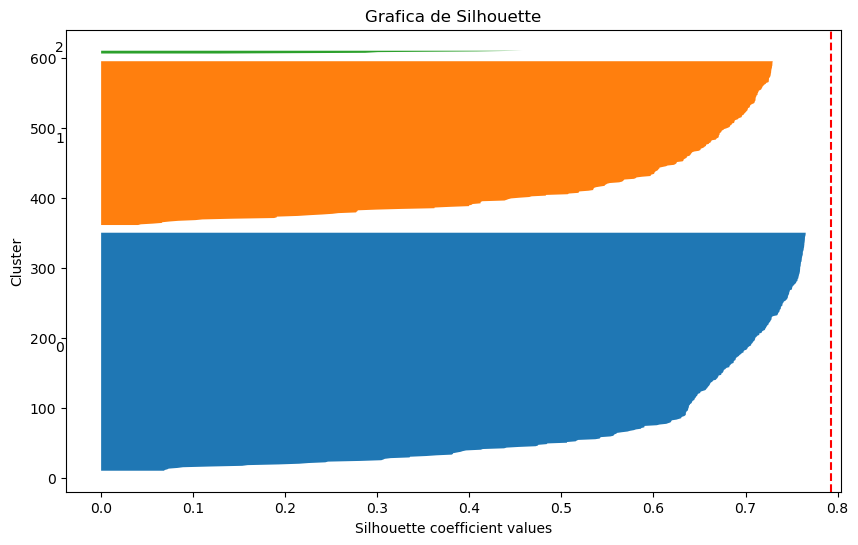

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples

# Graficamos Silhouette score.

pred_pd = predictions.select("features", "prediction").toPandas()
X = np.vstack(pred_pd["features"].values)
labels = pred_pd["prediction"].values

sample_values = silhouette_samples(X, labels)

plt.figure(figsize=(10, 6))
y_lower = 10
for i in np.unique(labels):
    ith_cluster_silhouette_values = sample_values[labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values)
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

plt.axvline(x=silhouette, color="red", linestyle="--")
plt.xlabel("Silhouette coefficient values")
plt.ylabel("Cluster")
plt.title("Grafica de Silhouette")
plt.show()

In [ ]:
# Juntar las previsiones de cluster con la tabla RFM final
clientes_clusterizados = rfm_final.join(predictions.select("customer_id", col("prediction").alias("cluster")), "customer_id", "inner")
print("Tabela final com RFM Scores e Cluster:")
clientes_clusterizados.show(10)

Tabela final com RFM Scores e Cluster:
+-----------+--------+----------+---------+-------+-------+-------+---------+-------+
|customer_id|Recencia|Frequencia|Monetario|R_Score|F_Score|M_Score|RFM_Score|cluster|
+-----------+--------+----------+---------+-------+-------+-------+---------+-------+
|          0|    1003|         1|  56700.0|      2|      2|      4|      224|      1|
|          1|     514|        22|   9100.0|      4|      5|      2|      452|      0|
|          2|    1530|         1|   2796.0|      1|      2|      1|      121|      1|
|          5|    1529|         2|    658.0|      1|      3|      1|      131|      1|
|          8|     509|         9| 102256.0|      4|      4|      4|      444|      0|
|         10|     684|         6|  10556.0|      3|      4|      2|      342|      0|
|         12|     899|        12| 434396.0|      2|      5|      5|      255|      1|
|         13|     901|         8| 712876.0|      2|      4|      5|      245|      1|
|         15|  

In [ ]:
# Analisar las características de cada cluster
print("\nAnálise das características médias por cluster:")
clientes_clusterizados.groupBy("cluster") \
    .agg(avg("Recencia").alias("Recencia_Media"), \
         avg("Frequencia").alias("Frequencia_Media"), \
         avg("Monetario").alias("Monetario_Medio"), \
         countDistinct("customer_id").alias("Num_Clientes")) \
    .orderBy("cluster") \
    .show()


Análise das características médias por cluster:
+-------+------------------+------------------+------------------+------------+
|cluster|    Recencia_Media|  Frequencia_Media|   Monetario_Medio|Num_Clientes|
+-------+------------------+------------------+------------------+------------+
|      0|477.04398826979474|13.222873900293255|146428.19129233577|         341|
|      1| 1106.344680851064| 4.302127659574468|45660.339516439366|         235|
|      2|             487.6|             297.4|       2760774.372|           5|
+-------+------------------+------------------+------------------+------------+



Modelo para analisis de la clusterizacion.

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

#Usando solo las columnas que vamos analisar
Gboost_data = clientes_clusterizados["R_Score","F_Score","M_Score", "cluster"]

# Indexação da variável target
label_indexer = StringIndexer(inputCol="cluster", outputCol="indexedLabel")

# Vetorização das features
feature_assembler = VectorAssembler(
    inputCols=["R_Score", "F_Score", "M_Score"],
    outputCol="features"
)


In [ ]:


# Modelo GBT - No funciona en este caso pues trabaja solo con binarios. ASi que cambiamos a un randon forest.
gbt = GBTClassifier(labelCol="indexedLabel", featuresCol="features", maxIter=10)

#Modelo Randon Forest
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="features", numTrees=100)

# Pipeline
pipeline = Pipeline(stages=[label_indexer, feature_assembler, rf])

(train_data, test_data) = Gboost_data.randomSplit([0.7, 0.3], seed=42)
 
# Treinamento
model = pipeline.fit(train_data)

# Previsão
predictions = model.transform(test_data)

# Avaliação
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy"
)
accuracy = evaluator.evaluate(predictions)

predictionAndLabels = predictions.select("prediction", "indexedLabel").rdd.map(tuple)
metrics = MulticlassMetrics(predictionAndLabels)

print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(metrics.confusionMatrix())



/usr/local/spark/python/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Accuracy: 0.98
Confusion Matrix:
DenseMatrix([[81.,  1.,  0.],
             [ 0., 63.,  0.],
             [ 2.,  0.,  0.]])


6. Modelo de Recomendaciones de Productos (ALS - Collaborative Filtering)

In [ ]:
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import expr

In [ ]:
# Certificar que os IDs são inteiros e não nulos
als_data = df_ordens.select(
    col("customer_id").cast(IntegerType()),
    col("product_id").cast(IntegerType()),
    col("product_qty").cast(FloatType()) # Usando cantidad como 'rating' implícito
).na.drop() # Quitar lineas donde customer_id o product_id son nulos mismo despues del cast

In [ ]:
# renombrar columnas para el patron de ALS
als_data = als_data.withColumnRenamed("customer_id", "userCol") \
                   .withColumnRenamed("product_id", "itemCol") \
                   .withColumnRenamed("product_qty", "ratingCol")

In [ ]:
# Dividir datos en train y test 
(training, test) = als_data.randomSplit([0.8, 0.2], seed=1234)

In [ ]:
# Construir modelo ALS con una configuracion basica
als_model = ALS(userCol="userCol", itemCol="itemCol", ratingCol="ratingCol",
          implicitPrefs=True, coldStartStrategy="drop",
          nonnegative=True)

In [ ]:
from pyspark.sql.functions import explode
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

# test de los hiperparametros para ajuste.
paramGrid = ParamGridBuilder() \
    .addGrid(als_model.rank, [10, 20, 30]) \
    .addGrid(als_model.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(als_model.alpha, [0.5, 1.0, 2.0]) \
    .build()


#cross validator Evaluator

evaluator = RegressionEvaluator(metricName="rmse", labelCol="ratingCol", predictionCol="prediction")

cv = CrossValidator(estimator=als_model,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=3)

# Entrenar el modelo
cv_model = cv.fit(training)

# Mejor modelo
mejor_modelo = cv_model.bestModel

# Previsiones en el conjunto de test
previsoes = mejor_modelo.transform(test)

# Cálculo de RMSE y MAE
rmse = evaluator.evaluate(previsoes.na.drop(subset=["prediction"]))
print(f"Melhor RMSE no teste: {rmse}")
evaluator_mae = RegressionEvaluator(metricName="mae", labelCol="ratingCol", predictionCol="prediction")
mae = evaluator_mae.evaluate(previsoes)
print(f"Mean Absolute Error (MAE):    {mae:.4f}")

# Generar las recomendaciones formatadas
recomendaciones = mejor_modelo.recommendForAllUsers(5)


KeyboardInterrupt: 

In [ ]:
print("Top 5 Recomendaciones por usuario (IDs de Produto):")
recomendaciones.show(10, truncate=False)

Top 5 Recomendaciones por usuario (IDs de Produto):
+-------+-------------------------------------------------------------------------------------------------------+
|userCol|recommendations                                                                                        |
+-------+-------------------------------------------------------------------------------------------------------+
|580    |[{5674, 0.8311895}, {2418, 0.7814818}, {14536, 0.75606006}, {19808, 0.74783796}, {17766, 0.7012954}]   |
|470    |[{19808, 0.93692124}, {20412, 0.88025147}, {12956, 0.7969291}, {14536, 0.6735073}, {2418, 0.66678643}] |
|430    |[{2678, 1.188983}, {13610, 1.1402546}, {13609, 1.1097128}, {10594, 1.1010408}, {16620, 1.1009189}]     |
|450    |[{12936, 0.6646481}, {21148, 0.44092023}, {20262, 0.43391424}, {2786, 0.4117555}, {14619, 0.39823347}] |
|80     |[{15167, 1.8881321}, {10945, 1.2174681}, {11630, 1.0428602}, {6685, 1.02357}, {14808, 0.9978072}]      |
|60     |[{2786, 1.3523881}, {12956,

In [ ]:
# Formatear las recomendaciones para mejor visualizarlas
user_recs_formatted = recomendaciones.withColumn("rec_exp", expr("explode(recommendations)")) \
                               .select("userCol", col("rec_exp.itemCol").alias("product_id"), col("rec_exp.rating").alias("predicted_rating"))
print("Recomendaciones formateadas (Usuário, Produto ID, Rating Predito):")
user_recs_formatted.show(20)

Recomendaciones formateadas (Usuário, Produto ID, Rating Predito):
+-------+----------+----------------+
|userCol|product_id|predicted_rating|
+-------+----------+----------------+
|    580|      5674|       0.8311895|
|    580|      2418|       0.7814818|
|    580|     14536|      0.75606006|
|    580|     19808|      0.74783796|
|    580|     17766|       0.7012954|
|    470|     19808|      0.93692124|
|    470|     20412|      0.88025147|
|    470|     12956|       0.7969291|
|    470|     14536|       0.6735073|
|    470|      2418|      0.66678643|
|    430|      2678|        1.188983|
|    430|     13610|       1.1402546|
|    430|     13609|       1.1097128|
|    430|     10594|       1.1010408|
|    430|     16620|       1.1009189|
|    450|     12936|       0.6646481|
|    450|     21148|      0.44092023|
|    450|     20262|      0.43391424|
|    450|      2786|       0.4117555|
|    450|     14619|      0.39823347|
+-------+----------+----------------+
only showing top 20 r

In [ ]:
# Juntar con nombres de productos para que sean mas legíveis
# Seleccionar apenas id e nombre del producto para el join
df_produtos_nomes = df_produtos.select(col("product_id").cast(IntegerType()), "post_title")

user_recs_final = user_recs_formatted.join(df_produtos_nomes, user_recs_formatted.product_id == df_produtos_nomes.product_id, "left") \
                                  .select(
    col("userCol"),
    df_produtos_nomes.product_id.alias("product_id"),
    col("post_title"),
    col("predicted_rating")
)

In [ ]:
# Agruparlos para ver los top 5 por usuário de forma mais clara
from pyspark.sql.window import Window
from pyspark.sql.functions import rank, collect_list
from pyspark.sql.functions import struct

window_spec = Window.partitionBy("userCol").orderBy(col("predicted_rating").desc())

user_recs_grouped = user_recs_final \
    .withColumn("rank", rank().over(window_spec)) \
    .where(col("rank") <= 5) \
    .groupBy("userCol") \
    .agg(collect_list(struct("product_id", "post_title", "predicted_rating")).alias("top_5_recomendaciones"))
    
user_recs_grouped.show(10, truncate=False)

+-------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|userCol|top_5_recomendacoes                                                                                                                                                                                                                                                                                   |
+-------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|26     |[{614, HP 15-EF2747WM, 1.3718138}, {14215, ASROCK A520M PRO4, 1.3688942}, {1

#### CHURN

NO ESTÁ BIEN.

7. Modelo de Previsão de Churn

In [ ]:
from pyspark.sql.functions import datediff, current_date, lit, avg as spark_avg, count as spark_count, max as spark_max, struct
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

In [ ]:
# 7.1 Definição de Churn e Criação de Labels
# Definir churn: Cliente que não fez compra nos últimos X dias (ex: 90 dias)
# Este valor pode ser ajustado com base no conhecimento do negócio
churn_threshold_days = 90

In [ ]:
# Usar a tabela RFM que já tem a Recência (dias desde a última compra)
# Se Recencia > churn_threshold_days, então churn = 1, senão 0
# Certificar que rfm_final está disponível
if 'rfm_final' not in locals():
    print("Erro: Tabela rfm_final não encontrada. Execute a etapa RFM primeiro.")
    # Adicionar código para recarregar ou recalcular rfm_final se necessário
    # Por exemplo:
    # rfm_r = df_ordens.groupBy("customer_id").agg(spark_min("recencia_ordem_dias").alias("Recencia"))
    # rfm_f = df_ordens.groupBy("customer_id").agg(countDistinct("order_id").alias("Frequencia"))
    # rfm_m = df_ordens.groupBy("customer_id").agg(spark_sum("product_gross_revenue").alias("Monetario"))
    # rfm_final = rfm_r.join(rfm_f, "customer_id", "inner").join(rfm_m, "customer_id", "inner")

In [ ]:
churn_labels = rfm_final.withColumn("churn_label",
                                    when(col("Recencia") > churn_threshold_days, 1).otherwise(0))

In [ ]:
print(f"Definindo churn como inatividade > {churn_threshold_days} dias.")
churn_labels.groupBy("churn_label").count().show()

Definindo churn como inatividade > 90 dias.
+-----------+-----+
|churn_label|count|
+-----------+-----+
|          1|   80|
+-----------+-----+



In [ ]:
# 7.2 Feature Engineering Adicional
# Juntar com df_clientes para obter 'dias_desde_registro'
# Certificar que df_clientes está disponível e processado
if 'df_clientes' not in locals() or 'dias_desde_registro' not in df_clientes.columns:
     print("Erro: df_clientes ou coluna 'dias_desde_registro' não encontrada.")
     # Recarregar/reprocessar df_clientes se necessário
     # df_clientes = spark.read.csv(path_clientes, header=True, inferSchema=True, sep=',')
     # df_clientes = df_clientes.dropDuplicates(['user_id'])
     # df_clientes = df_clientes.withColumn("user_registered_ts", to_timestamp(col("user_registered"), "yyyy-MM-dd HH:mm:ss"))
     # df_clientes = df_clientes.withColumn("dias_desde_registro", datediff(current_date(), col("user_registered_ts")))

In [ ]:
churn_data = churn_labels.join(df_clientes.select(col("user_id").alias("customer_id_ref"), "dias_desde_registro"),
                               churn_labels.customer_id == col("customer_id_ref"), "left") \
                         .select("customer_id", "Recencia", "Frequencia", "Monetario", "dias_desde_registro", "churn_label") \
                         .na.fill(0, subset=["dias_desde_registro"]) # Preencher nulos em dias_desde_registro (ex: se cliente não encontrado)

In [ ]:
print("Dados preparados para modelo de churn:")
churn_data.show(5)

Dados preparados para modelo de churn:
+-----------+--------+----------+-----------------+-------------------+-----------+
|customer_id|Recencia|Frequencia|        Monetario|dias_desde_registro|churn_label|
+-----------+--------+----------+-----------------+-------------------+-----------+
|        737|     134|         2|          4715.28|                  0|          1|
|        516|     154|         1|           1044.3|                  0|          1|
|        580|     197|         2|           1770.0|                  0|          1|
|        513|     198|        13|50761.23999999999|                  0|          1|
|        613|     210|         1|           1534.0|                  0|          1|
+-----------+--------+----------+-----------------+-------------------+-----------+
only showing top 5 rows



In [ ]:
# 7.3 Preparação para Modelagem (VectorAssembler, Scaler, Split)
# Colunas de features
feature_cols = ["Recencia", "Frequencia", "Monetario", "dias_desde_registro"]

In [ ]:
# Montar vetor de features
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_raw", handleInvalid="skip") # Skip rows with nulls

In [ ]:
# Escalar features numéricas (importante para regressão logística)
scaler_churn = StandardScaler(inputCol="features_raw", outputCol="features", withStd=True, withMean=True)

In [ ]:
# Criar pipeline para pré-processamento
preprocess_pipeline = Pipeline(stages=[assembler, scaler_churn])
preprocess_model = preprocess_pipeline.fit(churn_data)
final_churn_data = preprocess_model.transform(churn_data)

In [ ]:
# Selecionar colunas finais e renomear label
final_churn_data = final_churn_data.select(col("customer_id"), col("features"), col("churn_label").alias("label"))

In [ ]:
print("Dados finais com features escaladas e label:")
final_churn_data.show(5, truncate=False)

Dados finais com features escaladas e label:
+-----------+------------------------------------------------------------------------------------+-----+
|customer_id|features                                                                            |label|
+-----------+------------------------------------------------------------------------------------+-----+
|737        |[-1.2204026035000965,-0.33474376723009847,-0.34684949808465804,-0.6423398862187408] |1    |
|516        |[-0.9020713081626082,-0.3828218666527338,-0.40099505711315014,-0.6423398862187408]  |1    |
|580        |[-0.21765902318700828,-0.33474376723009847,-0.39029125807665943,-0.6423398862187408]|1    |
|513        |[-0.20174245842013386,0.1941153264188905,0.3323109019184983,-0.6423398862187408]    |1    |
|613        |[-0.010743681217640863,-0.3828218666527338,-0.39377216833242873,-0.6423398862187408]|1    |
+-----------+------------------------------------------------------------------------------------+-----+
only showi

In [ ]:
# Verificar se há dados suficientes após pré-processamento
if final_churn_data.count() == 0:
    print("Erro: Nenhum dado restante após pré-processamento para o modelo de churn.")
else:
    # Dividir em treino e teste
    (train_data, test_data) = final_churn_data.randomSplit([0.8, 0.2], seed=42)
    print(f"Registros de treino: {train_data.count()}, Registros de teste: {test_data.count()}")

    # 7.4 Treinamento do Modelo (Ex: Regressão Logística)
    if train_data.count() > 0:
        lr = LogisticRegression(featuresCol="features", labelCol="label")
        lr_model = lr.fit(train_data)
        print("Modelo de Regressão Logística treinado.")

        # 7.5 Avaliação do Modelo
        if test_data.count() > 0:
            predictions_lr = lr_model.transform(test_data)
            print("Predições no conjunto de teste:")
            predictions_lr.select("customer_id", "label", "probability", "prediction").show(10, truncate=False)

            # Avaliar usando AUC
            evaluator_auc = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderROC")
            # Lidar com possíveis NaNs na coluna de predição se houver
            auc = evaluator_auc.evaluate(predictions_lr.na.drop(subset=["rawPrediction"]))
            print(f"Área sob a curva ROC (AUC) no conjunto de teste: {auc}")

            # Avaliar usando outras métricas (Accuracy, Precision, Recall, F1)
            evaluator_multi = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
            accuracy = evaluator_multi.evaluate(predictions_lr, {evaluator_multi.metricName: "accuracy"})
            precision = evaluator_multi.evaluate(predictions_lr, {evaluator_multi.metricName: "weightedPrecision"})
            recall = evaluator_multi.evaluate(predictions_lr, {evaluator_multi.metricName: "weightedRecall"})
            f1 = evaluator_multi.evaluate(predictions_lr, {evaluator_multi.metricName: "f1"})

            print(f"Accuracy: {accuracy}")
            print(f"Precision: {precision}")
            print(f"Recall: {recall}")
            print(f"F1 Score: {f1}")
        else:
            print("Não há dados de teste suficientes para avaliação.")
    else:
        print("Não há dados de treino suficientes para treinar o modelo.")

Registros de treino: 63, Registros de teste: 17
Modelo de Regressão Logística treinado.
Predições no conjunto de teste:
+-----------+-----+-----------+----------+
|customer_id|label|probability|prediction|
+-----------+-----+-----------+----------+
|30         |1    |[0.0,1.0]  |1.0       |
|72         |1    |[0.0,1.0]  |1.0       |
|80         |1    |[0.0,1.0]  |1.0       |
|172        |1    |[0.0,1.0]  |1.0       |
|244        |1    |[0.0,1.0]  |1.0       |
|260        |1    |[0.0,1.0]  |1.0       |
|279        |1    |[0.0,1.0]  |1.0       |
|327        |1    |[0.0,1.0]  |1.0       |
|432        |1    |[0.0,1.0]  |1.0       |
|435        |1    |[0.0,1.0]  |1.0       |
+-----------+-----+-----------+----------+
only showing top 10 rows

Área sob a curva ROC (AUC) no conjunto de teste: 1.0
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


In [ ]:
# 1. Avaliador AUC e AUC-PR
evaluator_auc = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderROC")
evaluator_pr = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderPR")

# Lidar com possíveis NaNs na coluna de predição se houver (ex: coldStartStrategy)
valid_predictions = predictions_lr.na.drop(subset=["rawPrediction", "prediction", "label"])

if valid_predictions.count() == 0:
    print("Não há predições válidas para avaliação após remover NaNs.")
else: 
    print("Há predições válidas para avaliação após remover NaNs.")

Há predições válidas para avaliação após remover NaNs.


In [ ]:
auc_score = evaluator_auc.evaluate(valid_predictions)
pr_auc_score = evaluator_pr.evaluate(valid_predictions)
print(f"Área sob a Curva ROC (AUC): {auc_score:.4f}")
print(f"Área sob a Curva Precision-Recall (AUC-PR): {pr_auc_score:.4f}")



Área sob a Curva ROC (AUC): 1.0000
Área sob a Curva Precision-Recall (AUC-PR): 1.0000


In [ ]:
# 2. Avaliador Multiclasse para Accuracy, Precision, Recall, F1
evaluator_multi = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

accuracy = evaluator_multi.evaluate(valid_predictions, {evaluator_multi.metricName: "accuracy"})
precision_w = evaluator_multi.evaluate(valid_predictions, {evaluator_multi.metricName: "weightedPrecision"})
recall_w = evaluator_multi.evaluate(valid_predictions, {evaluator_multi.metricName: "weightedRecall"})
f1_w = evaluator_multi.evaluate(valid_predictions, {evaluator_multi.metricName: "f1"})

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision Ponderada: {precision_w:.4f}")
print(f"Recall Ponderado: {recall_w:.4f}")
print(f"F1-Score Ponderado: {f1_w:.4f}")




Accuracy: 1.0000
Precision Ponderada: 1.0000
Recall Ponderado: 1.0000
F1-Score Ponderado: 1.0000


In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Verifique as labels presentes
present_labels = valid_predictions.select("label").distinct().rdd.flatMap(lambda x: x).collect()

evaluator_multi = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

for label in present_labels:
    precision = evaluator_multi.evaluate(valid_predictions, {
        evaluator_multi.metricName: "precisionByLabel",
        evaluator_multi.metricLabel: label
    })
    recall = evaluator_multi.evaluate(valid_predictions, {
        evaluator_multi.metricName: "recallByLabel",
        evaluator_multi.metricLabel: label
    })
    f1 = evaluator_multi.evaluate(valid_predictions, {
        evaluator_multi.metricName: "f1",
        evaluator_multi.metricLabel: label
    })

    print(f"Label {label}: Precision = {precision:.4f}, Recall = {recall:.4f}, F1 = {f1:.4f}")

# 3. Métricas por Classe
print("\n-- Métricas por Classe --")
labels = [0.0, 1.0]
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# 🔍 Verifique quais classes realmente estão presentes
labels_presentes = valid_predictions.select("label").distinct().rdd.flatMap(lambda x: x).collect()

print("\n-- Métricas por Classe (presentes nos dados) --")
for label in sorted(labels_presentes):
    evaluator.setMetricLabel(label)

    evaluator.setMetricName("precisionByLabel")
    precision = evaluator.evaluate(valid_predictions)

    evaluator.setMetricName("recallByLabel")
    recall = evaluator.evaluate(valid_predictions)

    evaluator.setMetricName("f1")
    f1 = evaluator.evaluate(valid_predictions)

    print(f"Label {label}: Precision = {precision:.4f}, Recall = {recall:.4f}, F1 = {f1:.4f}")

    


Label 1: Precision = 1.0000, Recall = 1.0000, F1 = 1.0000

-- Métricas por Classe --

-- Métricas por Classe (presentes nos dados) --
Label 1: Precision = 1.0000, Recall = 1.0000, F1 = 1.0000


In [ ]:
# 4. Matriz de Confusão (Cálculo com PySpark)
print("\n-- Matriz de Confusão --")
# Calcula TP, TN, FP, FN diretamente
tp = valid_predictions.filter("label = 1.0 AND prediction = 1.0").count()
tn = valid_predictions.filter("label = 0.0 AND prediction = 0.0").count()
fp = valid_predictions.filter("label = 0.0 AND prediction = 1.0").count()
fn = valid_predictions.filter("label = 1.0 AND prediction = 0.0").count()

print(f"                 Predito 0 | Predito 1")
print(f"Real 0 (Não Churn):  {tn:^8} | {fp:^8}")
print(f"Real 1 (Churn):      {fn:^8} | {tp:^8}")


-- Matriz de Confusão --
                 Predito 0 | Predito 1
Real 0 (Não Churn):     0     |    0    
Real 1 (Churn):         0     |    17   


Próximo passo: Finalizar e entregar o notebook

In [ ]:
# Finalizar SparkSession
spark.stop()
print("SparkSession finalizada.")